# Fit Models on Different Samples With Resampling Ensembles

Ensemble learning are methods that combine the predictions from multiple models. It is important in ensemble learning that the ensemble models are good, making different prediction errors. Predictions that are good in different ways can result in a prediction that is both more stable and often better than the predictions of any individual member model. One way to achieve differences between models is to train each model on a different subset of the available training data. Models are trained on different subsets of the training data naturally through resampling methods such as cross-validation and the bootstrap, designed to estimate the average performance of the model generally on unseen data. The models used in this estimation process can be combined in what is referred to as a resampling-based ensemble, such as a cross-validation ensemble or a bootstrap aggregation (or bagging) ensemble. In this tutorial, you will discover how to develop a suite of different resampling-based ensembles for deep learning neural network models. After completing this tutorial, you will know:

* How to estimate model performance using random splits and develop an ensemble from the models.
* How to estimate performance using 10-fold cross-validation and develop a cross-validation ensemble.
* How to estimate performance using the bootstrap and combine models using a bagging ensemble.

## Resampling Ensembles

Combining the predictions from multiple models can result in more stable predictions, and in some cases, predictions that have better performance than any of the contributing models. Effective ensembles require members that disagree. Each member must have the skill (e.g., perform better than random chance), but ideally, perform well in different ways. Technically, we can say that we prefer ensemble members to have low correlation in their predictions or prediction errors.

One approach to encourage differences between ensembles is to use the same learning algorithm on different training datasets. This can be achieved by repeatedly resampling a training dataset that is in turn used to train a new model. Multiple models are fit using slightly different perspectives on the training data and, in turn, make different errors and often more stable and better predictions when combined. We can refer to these methods generally as data resampling ensembles. A benefit of this approach is that resampling methods may be used that do not use all examples in the training dataset. Any examples that are not used to fit the model can be used as a test dataset to estimate the generalization error of the chosen model configuration. There are three popular resampling methods that we could use to create a resampling ensemble; they are:

* **Random Splits**. The dataset is repeatedly sampled with a random split of the data into train and test sets.
* **k-fold Cross-Validation**. The dataset is split into k equally sized folds, k models are trained, and each fold is given an opportunity to be used as the holdout set where the model is trained on all remaining folds.
* **Bootstrap Aggregation**. Random samples are collected with replacement, and examples not included in a given sample are used as the test set.

Perhaps the most widely used resampling ensemble method is bootstrap aggregation, more commonly referred to as bagging. The resampling with replacement allows more difference in the training dataset, biasing the model and, in turn, resulting in more difference between the predictions of the resulting models. Resampling ensemble models make some specific assumptions about your project:

* A robust estimate of model performance on unseen data is required; if not, then a single train/test split can be used.
* There is a potential for a lift in performance using an ensemble of models; if not, then a single model fit on all available data can be used.
* The computational cost of fitting more than one neural network model on a sample of the training dataset is not prohibitive; if not, all resources should be put into fitting a single model.

Neural network models are remarkably flexible, therefore the lift in performance provided by a resampling ensemble is not always possible given that individual models trained on all available data can perform so well. As such, the sweet spot for using a resampling ensemble is the case where there is a requirement for a robust estimate of performance, and multiple models can be fit to calculate the estimate, but there is also a requirement for one (or more) of the models created during the estimate of performance to be used as the final model (e.g., a new final model cannot be fit on all available training data). Now that we are familiar with resampling ensemble methods, we can work through an example of applying each method in turn.

## Resampling Ensembles Case Study

In this section, we will demonstrate how to use the resampling ensemble to reduce the variance of an MLP on a simple multiclass classification problem. This example provides a template for applying the resampling ensemble to your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate a model resampling ensembles. The scikit-learn class provides the `make_blobs()` function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. We use this problem with 1,000 examples, with input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same 1,000 points.

In [1]:
from sklearn.datasets import make_blobs

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

The results are the input and output elements of a dataset that we can model. In order to get a feeling for the complexity of the problem, we can graph each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

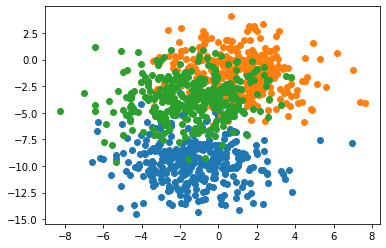

In [2]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)

    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable because the problem is non-trivial and will allow a neural network model to find many different *good enough* candidate solutions resulting in a high variance.

### Single Multilayer Perceptron Model

We will define a Multilayer Perceptron neural network or MLP that learns the problem reasonably well. The problem is a multiclass classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, the first step is to one-hot encode the class values.

In [3]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y)

Next, we must split the dataset into training and test sets. We will use the test set both to evaluate the model's performance and to plot its performance during training with a learning curve. We will use 90% of the data for training and 10% for the test set. We are choosing a large split because it is a noisy problem and a well-performing model requires as much data as possible to learn the complex classification function.

In [4]:
# split into train and test
n_train = int(0.9 * X.shape[0])

trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

Next, we can define and compile the model. The model will expect samples with two input variables. The model then has a single hidden layer with 50 nodes and a rectified linear activation function, an output layer with three nodes to predict the probability of each of the three classes, and a softmax activation function. Because the problem is multiclass, we will use the categorical cross-entropy loss function to optimize the model and the efficient Adam flavor of stochastic gradient descent.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The model is fit for 50 training epochs, and we will evaluate each epoch on the test set, using the test set as a validation set.

In [6]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=50, verbose=1)

Epoch 1/50
29/29 [==============================] - 1s 11ms/step - loss: 1.0946 - accuracy: 0.4896 - val_loss: 0.7499 - val_accuracy: 0.6500
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 0.7967 - accuracy: 0.6158 - val_loss: 0.6373 - val_accuracy: 0.7500
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 0.7044 - accuracy: 0.6780 - val_loss: 0.5784 - val_accuracy: 0.7700
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6722 - accuracy: 0.7014 - val_loss: 0.5432 - val_accuracy: 0.7900
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6582 - accuracy: 0.7019 - val_loss: 0.5168 - val_accuracy: 0.8300
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6197 - accuracy: 0.7359 - val_loss: 0.4833 - val_accuracy: 0.8300
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6027 - accuracy: 0.7260 - val_loss: 0.4654 - val_accuracy: 0.8300
Epoch 8/50
29/29 [=

At the end of the run, we will evaluate the model's performance on both the train and the test sets.

In [7]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.828, Test: 0.860


Then finally, we will plot model loss and accuracy learning curves over each training epoch on both the training and test dataset.

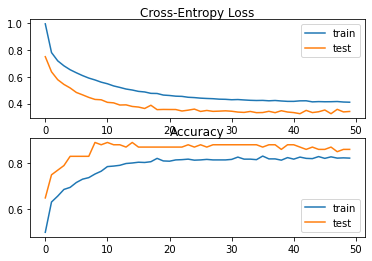

In [8]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

The complete example is listed below.

In [9]:
# fit high variance mlp on blobs classification problem
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = int(0.9 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=50, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.829, Test: 0.860


Running the example, it first prints the performance of the final model on the train and test datasets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model achieved about 83% accuracy on the training dataset and about 86% on the test dataset. The chosen split of the dataset into train and test sets means that the test set is small and not representative of the broader problem. In turn, performance on the test set is not representative of the model; in this case, it is optimistically biased.

A line plot also shows the learning curves for the model accuracy on the train and test sets over each training epoch. We can see that the model has a reasonably stable fit.

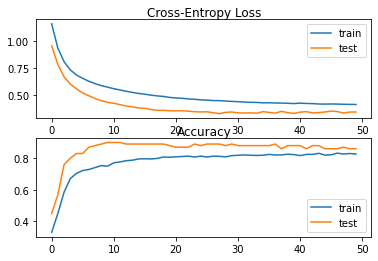

In [20]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

### Random Splits Ensemble

### Cross-Validation Ensemble

### Bagging Ensemble

## Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.

* **Single Model**. Compare the performance of each ensemble to one model trained on all available data.
* **CV Ensemble Size**. Experiment with larger and smaller ensemble sizes for the cross-validation ensemble and compare their performance.
* **Bagging Ensemble Limit**. Increase the number of members in the bagging ensemble to find the point of diminishing returns.

## Summary

In this tutorial, you discovered how to develop a suite of different resampling-based ensembles for deep learning neural network models. Specifically, you learned:

* How to estimate model performance using random splits and develop an ensemble from the models.
* How to estimate performance using 10-fold cross-validation and develop a cross-validation ensemble.
* How to estimate performance using the bootstrap and combine models using a bagging ensemble.